from google.colab import drive
drive.mount('/content/gdrive')

# Start

## install necessary package

! pip install jenkspy


## Imports

In [1]:
# %matplotlib notebook

# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from xgboost import XGBRegressor

import os
import pickle
import wordcloud as wc
import scipy.sparse as sparse
import xgboost as xgb
import random
import jenkspy
import statsmodels.tools.tools as stattools
from itertools import combinations

import sklearn
from sklearn import tree
from sklearn.model_selection import KFold,train_test_split
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction import DictVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

## load datasets

In [2]:
Dataset_path = "./DataSets/"
ml_path = Dataset_path + "ml-latest/"

links = pd.read_csv( ml_path + "links.csv")
movies = pd.read_csv( ml_path + "movies.csv")
ratings = pd.read_csv( ml_path + "ratings.csv")
tags = pd.read_csv( ml_path + "tags.csv")

genome_scores = pd.read_csv( ml_path + "genome-scores.csv")
genome_tags = pd.read_csv( ml_path + "genome-tags.csv")

In [3]:
IMDb_movies = pd.read_csv( Dataset_path+"IMDb movies extensive dataset/IMDb movies.csv")
IMDb_names = pd.read_csv( Dataset_path+"IMDb movies extensive dataset/IMDb names.csv")
IMDb_ratings = pd.read_csv( Dataset_path+"IMDb movies extensive dataset/IMDb ratings.csv")
IMDb_title_principals = pd.read_csv( Dataset_path+"IMDb movies extensive dataset/IMDb title_principals.csv")

E:\#darC\99-2 (8)\Data mining\Code\.FDM2021\lib\site-packages\IPython\core\interactiveshell.py:3155: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


# Data preparation phase

In [4]:
def df_Show( df, n=40 ):
    print( 'Dataset shape = ', df.shape)
    print("-"*n)
    display( df.loc[0] )
    print("-"*n)
    display( df.info(verbose=True) )
    print("-"*n)
    display( df.describe(include='all') )
    
#     display( df.hist(bins=50,figsize=(20,15)) )
##################################################
#     df.plot(subplots=True, layout=(4,5), figsize=(20,15))
#     plt.tight_layout()
#     plt.show()
##################################################
#     fig, axes = plt.subplots(len(df.columns)//3, 3, figsize=(12, 48))
#     i = 0
#     for triaxis in axes:
#         for axis in triaxis:
#             df.hist(column = df.columns[i], bins = 100, ax=axis)
#             i = i+1

## MovieLens Dataset

### links 

In [5]:
df_Show( links )

Dataset shape =  (58098, 3)
----------------------------------------


movieId         1.0
imdbId     114709.0
tmdbId        862.0
Name: 0, dtype: float64

----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58098 entries, 0 to 58097
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  58098 non-null  int64  
 1   imdbId   58098 non-null  int64  
 2   tmdbId   57917 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 1.3 MB


None

----------------------------------------


,movieId,imdbId,tmdbId
count,58098.000000,5.809800e+04,57917.000000
mean,111919.516197,1.192737e+06,133501.495761
std,59862.660956,1.701589e+06,133007.815686
min,1.000000,1.000000e+00,2.000000
25%,72437.750000,8.050625e+04,32194.000000
50%,126549.000000,2.905645e+05,77269.000000
75%,161449.500000,1.724964e+06,209231.000000
max,193886.000000,9.038520e+06,549443.000000


In [6]:
links.isna().sum()

movieId      0
imdbId       0
tmdbId     181
dtype: int64

In [7]:
del links['tmdbId']

array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

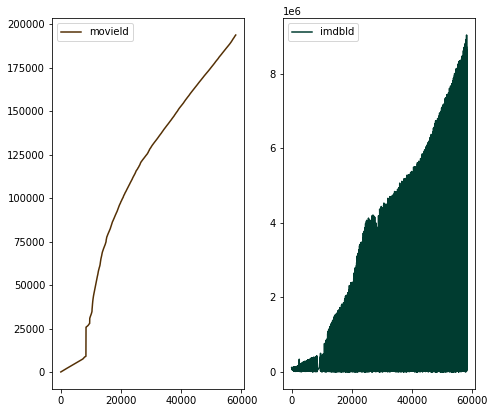

In [8]:
links.plot(kind='line', colormap='BrBG', subplots=True,layout=(2,5), figsize=(20,15))

### movies 

In [9]:
df_Show( movies )

Dataset shape =  (58098, 3)
----------------------------------------


movieId                                              1
title                                 Toy Story (1995)
genres     Adventure|Animation|Children|Comedy|Fantasy
Name: 0, dtype: object

----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58098 entries, 0 to 58097
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  58098 non-null  int64 
 1   title    58098 non-null  object
 2   genres   58098 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.3+ MB


None

----------------------------------------


,movieId,title,genres
count,58098.000000,58098,58098
unique,NaN,58020,1643
top,NaN,Rose (2011),Drama
freq,NaN,2,8402
mean,111919.516197,NaN,NaN
std,59862.660956,NaN,NaN
min,1.000000,NaN,NaN
25%,72437.750000,NaN,NaN
50%,126549.000000,NaN,NaN
75%,161449.500000,NaN,NaN


In [10]:
movies.isna().sum()

movieId    0
title      0
genres     0
dtype: int64

In [11]:
del movies['title']

Adventure :  4067
Animation :  2663
Children :  2749
Comedy :  15956
Fantasy :  2637
Romance :  7412
Drama :  24144
Action :  7130
Crime :  5105
Thriller :  8216
Horror :  5555
Mystery :  2773
Sci-Fi :  3444
IMAX :  197
Documentary :  5118
War :  1820
Musical :  1113
Western :  1378
Film-Noir :  364
(no genres listed) :  4266


<AxesSubplot:>

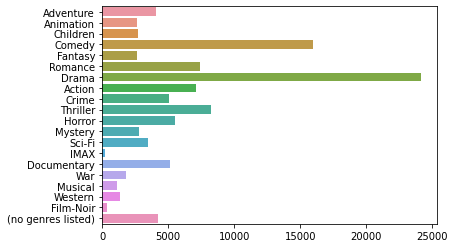

In [12]:
freq = {}

for item in movies['genres']:
    for subitem in item.split('|'):
        if (subitem in freq):
            freq[subitem] += 1
        else:
            freq[subitem] = 1

for key, value in freq.items():
    print ("% s : % d"%(key, value))
    
# plt.barh(*zip(*freq.items()))
sns.barplot(y=list(freq.keys()), x=list(freq.values()), orient='h')

In [13]:
movies[ movies['genres'].str.contains("Drama") ].head()

,movieId,genres
3,4,Comedy|Drama|Romance
10,11,Comedy|Drama|Romance
13,14,Drama
15,16,Crime|Drama
16,17,Drama|Romance


### ratings

In [14]:
df_Show( ratings )

Dataset shape =  (27753444, 4)
----------------------------------------


userId       1.000000e+00
movieId      3.070000e+02
rating       3.500000e+00
timestamp    1.256677e+09
Name: 0, dtype: float64

----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27753444 entries, 0 to 27753443
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 847.0 MB


None

----------------------------------------


,userId,movieId,rating,timestamp
count,2.775344e+07,2.775344e+07,2.775344e+07,2.775344e+07
mean,1.419420e+05,1.848800e+04,3.530445e+00,1.193122e+09
std,8.170740e+04,3.510263e+04,1.066353e+00,2.160482e+08
min,1.000000e+00,1.000000e+00,5.000000e-01,7.896520e+08
25%,7.117600e+04,1.097000e+03,3.000000e+00,9.986053e+08
50%,1.420220e+05,2.716000e+03,3.500000e+00,1.174256e+09
75%,2.124590e+05,7.150000e+03,4.000000e+00,1.422744e+09
max,2.832280e+05,1.938860e+05,5.000000e+00,1.537945e+09


In [15]:
del ratings['timestamp']

In [16]:
ratings.isna().sum()

userId     0
movieId    0
rating     0
dtype: int64

In [17]:
ratings['rating'].value_counts()

4.0    7394710
3.0    5515668
5.0    4071135
3.5    3404360
4.5    2373550
2.0    1850627
2.5    1373419
1.0     886233
0.5     442388
1.5     441354
Name: rating, dtype: int64

In [18]:
ratings['movieId'].value_counts()

318       97999
356       97040
296       92406
593       87899
2571      84545
          ...  
183821        1
191561        1
158809        1
175171        1
167550        1
Name: movieId, Length: 53889, dtype: int64

In [19]:
ratings['userId'].value_counts()

123100    23715
117490     9279
134596     8381
212343     7884
242683     7515
          ...  
6870          1
15905         1
121576        1
105187        1
62858         1
Name: userId, Length: 283228, dtype: int64

In [20]:
tmpDf = ratings.groupby('userId')['movieId'].count()>=20

ratings['Flag'] = ratings['userId'].apply(lambda x: tmpDf.loc[x] )

ratings2 = ratings[ ratings['Flag']==True ][['userId','movieId','rating']]
ratings2.reset_index(drop=True, inplace=True)

print('The original data frame shape:\t{}'.format( ratings.shape ))
print('The new data frame shape:\t{}'.format(ratings2.shape))

The original data frame shape:	(27753444, 4)
The new data frame shape:	(26544038, 3)


In [21]:
# ratings2.to_csv(Dataset_path +'CleanedRatings.csv', index=False)

### tags

In [22]:
df_Show( tags )

Dataset shape =  (1108997, 4)
----------------------------------------


userId               14
movieId             110
tag                epic
timestamp    1443148538
Name: 0, dtype: object

----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1108997 entries, 0 to 1108996
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   userId     1108997 non-null  int64 
 1   movieId    1108997 non-null  int64 
 2   tag        1108981 non-null  object
 3   timestamp  1108997 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 33.8+ MB


None

----------------------------------------


,userId,movieId,tag,timestamp
count,1.108997e+06,1.108997e+06,1108981,1.108997e+06
unique,NaN,NaN,74714,NaN
top,NaN,NaN,sci-fi,NaN
freq,NaN,NaN,9400,NaN
mean,1.248016e+05,5.492109e+04,NaN,1.413544e+09
std,7.726964e+04,5.618123e+04,NaN,1.144358e+08
min,1.400000e+01,1.000000e+00,NaN,1.135429e+09
25%,7.340600e+04,3.362000e+03,NaN,1.323903e+09
50%,1.030130e+05,4.374400e+04,NaN,1.446994e+09
75%,1.883600e+05,9.682100e+04,NaN,1.525549e+09


In [23]:
tags['tag'].value_counts()

sci-fi                   9400
atmospheric              6430
action                   6219
comedy                   5923
surreal                  5299
                         ... 
kathy                       1
hunks                       1
Johah Hill                  1
Excellent child actor       1
observational cinema        1
Name: tag, Length: 74714, dtype: int64

In [24]:
len(list(tags['tag'].unique()))

74715

In [25]:
tags[tags['userId']==14]

,userId,movieId,tag,timestamp
0,14,110,epic,1443148538
1,14,110,Medieval,1443148532
2,14,260,sci-fi,1442169410
3,14,260,space action,1442169421
4,14,318,imdb top 250,1442615195
5,14,318,justice,1442615192
6,14,480,Dinosaurs,1443148563
7,14,593,psychothriller,1444014286
8,14,1682,philosophy,1442615158
9,14,1682,surveillance,1442615167


### genome_scores

In [26]:
df_Show( genome_scores )

Dataset shape =  (14862528, 3)
----------------------------------------


movieId      1.000
tagId        1.000
relevance    0.029
Name: 0, dtype: float64

----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14862528 entries, 0 to 14862527
Data columns (total 3 columns):
 #   Column     Dtype  
---  ------     -----  
 0   movieId    int64  
 1   tagId      int64  
 2   relevance  float64
dtypes: float64(1), int64(2)
memory usage: 340.2 MB


None

----------------------------------------


,movieId,tagId,relevance
count,1.486253e+07,1.486253e+07,1.486253e+07
mean,3.997087e+04,5.645000e+02,1.153631e-01
std,4.814930e+04,3.256254e+02,1.554320e-01
min,1.000000e+00,1.000000e+00,2.500000e-04
25%,3.680750e+03,2.827500e+02,2.300000e-02
50%,7.880000e+03,5.645000e+02,5.450000e-02
75%,7.124900e+04,8.462500e+02,1.390000e-01
max,1.875950e+05,1.128000e+03,1.000000e+00


### genome_tags

In [27]:
df_Show( genome_tags )

Dataset shape =  (1128, 2)
----------------------------------------


tagId      1
tag      007
Name: 0, dtype: object

----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1128 entries, 0 to 1127
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tagId   1128 non-null   int64 
 1   tag     1128 non-null   object
dtypes: int64(1), object(1)
memory usage: 17.8+ KB


None

----------------------------------------


,tagId,tag
count,1128.000000,1128
unique,NaN,1128
top,NaN,teens
freq,NaN,1
mean,564.500000,NaN
std,325.769857,NaN
min,1.000000,NaN
25%,282.750000,NaN
50%,564.500000,NaN
75%,846.250000,NaN


In [28]:
genome_tags.head()

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


## imdb extensive dataset

### IMDb_movies

In [29]:
df_Show( IMDb_movies )

Dataset shape =  (85855, 22)
----------------------------------------


imdb_title_id                                                    tt0000009
title                                                           Miss Jerry
original_title                                                  Miss Jerry
year                                                                  1894
date_published                                                  1894-10-09
genre                                                              Romance
duration                                                                45
country                                                                USA
language                                                              None
director                                                   Alexander Black
writer                                                     Alexander Black
production_company                              Alexander Black Photoplays
actors                   Blanche Bayliss, William Courtenay, Chauncey D...
description              

----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85855 entries, 0 to 85854
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   imdb_title_id          85855 non-null  object 
 1   title                  85855 non-null  object 
 2   original_title         85855 non-null  object 
 3   year                   85855 non-null  object 
 4   date_published         85855 non-null  object 
 5   genre                  85855 non-null  object 
 6   duration               85855 non-null  int64  
 7   country                85791 non-null  object 
 8   language               85022 non-null  object 
 9   director               85768 non-null  object 
 10  writer                 84283 non-null  object 
 11  production_company     81400 non-null  object 
 12  actors                 85786 non-null  object 
 13  description            83740 non-null  object 
 14  avg_vote     

None

----------------------------------------


,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,...,actors,description,avg_vote,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics
count,85855,85855,85855,85855,85855,85855,85855.000000,85791,85022,85768,...,85786,83740,85855.000000,8.585500e+04,23710,15326,31016,13305.000000,78258.000000,74058.000000
unique,85855,82094,80852,168,22012,1257,NaN,4907,4377,34733,...,85729,83611,NaN,NaN,4642,14857,30414,NaN,NaN,NaN
top,tt9105628,Anna,Anna,2017,2010,Drama,NaN,USA,English,Jesús Franco,...,"Nobuyo Ôyama, Noriko Ohara, Michiko Nomura, Ka...",The story of,NaN,NaN,$ 1000000,$ 1000000,$ 8144,NaN,NaN,NaN
freq,1,10,10,3223,113,12543,NaN,28511,35939,87,...,9,15,NaN,NaN,758,19,15,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,100.351418,NaN,NaN,NaN,...,NaN,NaN,5.898656,9.493490e+03,NaN,NaN,NaN,55.896881,46.040826,27.479989
std,NaN,NaN,NaN,NaN,NaN,NaN,22.553848,NaN,NaN,NaN,...,NaN,NaN,1.234987,5.357436e+04,NaN,NaN,NaN,17.784874,178.511411,58.339158
min,NaN,NaN,NaN,NaN,NaN,NaN,41.000000,NaN,NaN,NaN,...,NaN,NaN,1.000000,9.900000e+01,NaN,NaN,NaN,1.000000,1.000000,1.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,88.000000,NaN,NaN,NaN,...,NaN,NaN,5.200000,2.050000e+02,NaN,NaN,NaN,43.000000,4.000000,3.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,96.000000,NaN,NaN,NaN,...,NaN,NaN,6.100000,4.840000e+02,NaN,NaN,NaN,57.000000,9.000000,8.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,108.000000,NaN,NaN,NaN,...,NaN,NaN,6.800000,1.766500e+03,NaN,NaN,NaN,69.000000,27.000000,23.000000


In [30]:
IMDb_movies['actors']

0        Blanche Bayliss, William Courtenay, Chauncey D...
1        Elizabeth Tait, John Tait, Norman Campbell, Be...
2        Asta Nielsen, Valdemar Psilander, Gunnar Helse...
3        Helen Gardner, Pearl Sindelar, Miss Fielding, ...
4        Salvatore Papa, Arturo Pirovano, Giuseppe de L...
                               ...                        
85850    Dany Boon, Philippe Katerine, Anne Serra, Samu...
85851    Herman Finkers, Johanna ter Steege, Leonie ter...
85852    Anoop Chandran, Indrans, Sona Nair, Simon Brit...
85853    Ahmet Faik Akinci, Belma Mamati, Metin Keçeci,...
85854    Maria Morera Colomer, Biel Rossell Pelfort, Is...
Name: actors, Length: 85855, dtype: object

### IMDb_names

In [31]:
df_Show( IMDb_names )

Dataset shape =  (297705, 17)
----------------------------------------


imdb_name_id                                                     nm0000001
name                                                          Fred Astaire
birth_name                                         Frederic Austerlitz Jr.
height                                                               177.0
bio                      Fred Astaire was born in Omaha, Nebraska, to J...
birth_details                         May 10, 1899 in Omaha, Nebraska, USA
date_of_birth                                                   1899-05-10
place_of_birth                                        Omaha, Nebraska, USA
death_details            June 22, 1987 in Los Angeles, California, USA ...
date_of_death                                                   1987-06-22
place_of_death                              Los Angeles, California, USA  
reason_of_death                                                  pneumonia
spouses_string           Robyn Smith  (27 June 1980 - 22 June 1987) (hi...
spouses                  

----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297705 entries, 0 to 297704
Data columns (total 17 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   imdb_name_id           297705 non-null  object 
 1   name                   297705 non-null  object 
 2   birth_name             297705 non-null  object 
 3   height                 44681 non-null   float64
 4   bio                    204698 non-null  object 
 5   birth_details          110612 non-null  object 
 6   date_of_birth          110612 non-null  object 
 7   place_of_birth         103992 non-null  object 
 8   death_details          39933 non-null   object 
 9   date_of_death          39933 non-null   object 
 10  place_of_death         37038 non-null   object 
 11  reason_of_death        22694 non-null   object 
 12  spouses_string         45352 non-null   object 
 13  spouses                297705 non-null  int64  


None

----------------------------------------


,imdb_name_id,name,birth_name,height,bio,birth_details,date_of_birth,place_of_birth,death_details,date_of_death,place_of_death,reason_of_death,spouses_string,spouses,divorces,spouses_with_children,children
count,297705,297705,297705,44681.000000,204698,110612,110612,103992,39933,39933,37038,22694,45352,297705.000000,297705.000000,297705.000000,297705.000000
unique,297705,291011,292421,NaN,204627,106879,45283,22335,39221,21269,8151,1975,45063,NaN,NaN,NaN,NaN
top,nm0228491,Dinesh,Dinesh,NaN,Diego Baldenweg (composer) with Nora Baldenweg...,1957,1957,"New York City, New York, USA",1995,1995,"Los Angeles, California, USA",undisclosed,? (? - present) (1 child),NaN,NaN,NaN,NaN
freq,1,9,9,NaN,3,47,47,3011,19,19,2332,5671,45,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,175.007162,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.208690,0.071722,0.104866,0.196439
std,NaN,NaN,NaN,14.055496,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.570208,0.348499,0.349762,0.721257
min,NaN,NaN,NaN,20.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000
25%,NaN,NaN,NaN,168.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000
50%,NaN,NaN,NaN,175.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000
75%,NaN,NaN,NaN,183.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000


### IMDb_ratings

In [32]:
df_Show( IMDb_ratings )

Dataset shape =  (85855, 49)
----------------------------------------


imdb_title_id                tt0000009
weighted_average_vote              5.9
total_votes                        154
mean_vote                          5.9
median_vote                        6.0
votes_10                            12
votes_9                              4
votes_8                             10
votes_7                             43
votes_6                             28
votes_5                             28
votes_4                              9
votes_3                              1
votes_2                              5
votes_1                             14
allgenders_0age_avg_vote           7.2
allgenders_0age_votes              4.0
allgenders_18age_avg_vote          6.0
allgenders_18age_votes            38.0
allgenders_30age_avg_vote          5.7
allgenders_30age_votes            50.0
allgenders_45age_avg_vote          6.6
allgenders_45age_votes            35.0
males_allages_avg_vote             6.2
males_allages_votes               97.0
males_0age_avg_vote      

----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85855 entries, 0 to 85854
Data columns (total 49 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   imdb_title_id              85855 non-null  object 
 1   weighted_average_vote      85855 non-null  float64
 2   total_votes                85855 non-null  int64  
 3   mean_vote                  85855 non-null  float64
 4   median_vote                85855 non-null  float64
 5   votes_10                   85855 non-null  int64  
 6   votes_9                    85855 non-null  int64  
 7   votes_8                    85855 non-null  int64  
 8   votes_7                    85855 non-null  int64  
 9   votes_6                    85855 non-null  int64  
 10  votes_5                    85855 non-null  int64  
 11  votes_4                    85855 non-null  int64  
 12  votes_3                    85855 non-null  int64  
 13  votes

None

----------------------------------------


,imdb_title_id,weighted_average_vote,total_votes,mean_vote,median_vote,votes_10,votes_9,votes_8,votes_7,votes_6,...,females_30age_avg_vote,females_30age_votes,females_45age_avg_vote,females_45age_votes,top1000_voters_rating,top1000_voters_votes,us_voters_rating,us_voters_votes,non_us_voters_rating,non_us_voters_votes
count,85855,85855.000000,8.585500e+04,85855.000000,85855.000000,8.585500e+04,85855.000000,85855.000000,85855.000000,85855.000000,...,84911.000000,84911.000000,83057.000000,83057.000000,85176.000000,85176.000000,85646.000000,85646.000000,85854.000000,85854.000000
unique,85855,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,tt9105628,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,5.898656,9.493490e+03,6.226342,6.267853,1.216158e+03,1196.774608,2040.896337,2105.668371,1353.192802,...,6.071223,685.655451,6.022226,196.065341,5.155706,76.110231,5.925910,1647.822537,5.749638,4332.940865
std,NaN,1.234987,5.357436e+04,1.155280,1.481168,1.245582e+04,11735.363316,13801.122865,10699.375191,5976.801303,...,1.454370,3732.376186,1.541895,842.979585,1.290920,124.264020,1.308087,8455.978158,1.285570,23243.807279
min,NaN,1.000000,9.900000e+01,1.000000,1.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,NaN,5.200000,2.050000e+02,5.600000,6.000000,2.100000e+01,8.000000,18.000000,28.000000,30.000000,...,5.300000,10.000000,5.200000,6.000000,4.400000,11.000000,5.200000,24.000000,5.000000,95.000000
50%,NaN,6.100000,4.840000e+02,6.400000,6.000000,5.100000e+01,24.000000,49.000000,77.000000,76.000000,...,6.300000,27.000000,6.200000,16.000000,5.300000,29.000000,6.100000,81.000000,6.000000,225.000000
75%,NaN,6.800000,1.766500e+03,7.000000,7.000000,1.920000e+02,111.500000,234.000000,342.000000,290.000000,...,7.000000,109.000000,7.000000,62.000000,6.000000,77.000000,6.800000,335.000000,6.700000,841.000000


### IMDb_title_principals

In [33]:
df_Show( IMDb_title_principals )

Dataset shape =  (835513, 6)
----------------------------------------


imdb_title_id                                   tt0000009
ordering                                                1
imdb_name_id                                    nm0063086
category                                          actress
job                                                   NaN
characters       ["Miss Geraldine Holbrook (Miss Jerry)"]
Name: 0, dtype: object

----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 835513 entries, 0 to 835512
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   imdb_title_id  835513 non-null  object
 1   ordering       835513 non-null  int64 
 2   imdb_name_id   835513 non-null  object
 3   category       835513 non-null  object
 4   job            212731 non-null  object
 5   characters     340836 non-null  object
dtypes: int64(1), object(5)
memory usage: 38.2+ MB


None

----------------------------------------


,imdb_title_id,ordering,imdb_name_id,category,job,characters
count,835513,835513.000000,835513,835513,212731,340836
unique,85848,NaN,297706,12,8871,212899
top,tt9105628,NaN,nm0001553,actor,producer,"[""Self""]"
freq,10,NaN,188,222337,97837,720
mean,NaN,5.398360,NaN,NaN,NaN,NaN
std,NaN,2.837061,NaN,NaN,NaN,NaN
min,NaN,1.000000,NaN,NaN,NaN,NaN
25%,NaN,3.000000,NaN,NaN,NaN,NaN
50%,NaN,5.000000,NaN,NaN,NaN,NaN
75%,NaN,8.000000,NaN,NaN,NaN,NaN


## Merge Phase

In [34]:
data01 = pd.merge(movies[['movieId','genres']],links[['movieId','imdbId']], how='inner' )
data01.head()

,movieId,genres,imdbId
0,1,Adventure|Animation|Children|Comedy|Fantasy,114709
1,2,Adventure|Children|Fantasy,113497
2,3,Comedy|Romance,113228
3,4,Comedy|Drama|Romance,114885
4,5,Comedy,113041


In [35]:
data01['imdbId'] = data01["imdbId"].apply(str)
data01['imdb_title_id'] = data01['imdbId'].apply(lambda x: "tt" + "0"*( 7-len(x) ) + x )
del data01['imdbId']

In [36]:
data02 = pd.merge(data01, IMDb_movies, how='inner')
data02.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41896 entries, 0 to 41895
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   movieId                41896 non-null  int64  
 1   genres                 41896 non-null  object 
 2   imdb_title_id          41896 non-null  object 
 3   title                  41896 non-null  object 
 4   original_title         41896 non-null  object 
 5   year                   41896 non-null  object 
 6   date_published         41896 non-null  object 
 7   genre                  41896 non-null  object 
 8   duration               41896 non-null  int64  
 9   country                41890 non-null  object 
 10  language               41648 non-null  object 
 11  director               41886 non-null  object 
 12  writer                 41621 non-null  object 
 13  production_company     40944 non-null  object 
 14  actors                 41877 non-null  object 
 15  de

In [37]:
data02.isna().sum()

movieId                      0
genres                       0
imdb_title_id                0
title                        0
original_title               0
year                         0
date_published               0
genre                        0
duration                     0
country                      6
language                   248
director                    10
writer                     275
production_company         952
actors                      19
description                307
avg_vote                     0
votes                        0
budget                   26443
usa_gross_income         28605
worlwide_gross_income    22009
metascore                30300
reviews_from_users        1168
reviews_from_critics      1776
dtype: int64

In [38]:
data02[data02.title.isnull()]

,movieId,genres,imdb_title_id,title,original_title,year,date_published,genre,duration,country,...,actors,description,avg_vote,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics


In [39]:
data03 = pd.merge(data02, IMDb_ratings[['imdb_title_id','mean_vote','total_votes']], how='inner')
data03.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41896 entries, 0 to 41895
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   movieId                41896 non-null  int64  
 1   genres                 41896 non-null  object 
 2   imdb_title_id          41896 non-null  object 
 3   title                  41896 non-null  object 
 4   original_title         41896 non-null  object 
 5   year                   41896 non-null  object 
 6   date_published         41896 non-null  object 
 7   genre                  41896 non-null  object 
 8   duration               41896 non-null  int64  
 9   country                41890 non-null  object 
 10  language               41648 non-null  object 
 11  director               41886 non-null  object 
 12  writer                 41621 non-null  object 
 13  production_company     40944 non-null  object 
 14  actors                 41877 non-null  object 
 15  de

In [40]:
data03.to_csv(Dataset_path +'MoviesInfo.csv', index=False)